### Imports

In [1]:
import sklearn
from sklearn import *
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import tensorly as tl
from tensorly import *
import scipy

Using numpy backend.


### Load the dataset

In [66]:
path = "./data_3_variables/"
n_person = 10
n_view = 9
n_illum = 6
x_size = 200
y_size = 200

images = np.empty((n_person, n_view, n_illum, x_size* y_size))
for im_name in os.listdir(path):
    parsed = im_name.split("_")
    person = int(parsed[0])
    view   = int(-int(parsed[1])/4)
    illum  = int(int(parsed[4])/15)-1
    images[person, view, illum] = cv2.resize(cv2.imread( path+im_name, 0), (x_size, y_size)).reshape(-1)/ 255.

(-0.5, 199.5, 199.5, -0.5)

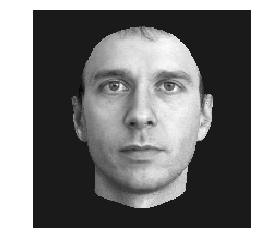

In [202]:
plt.imshow(images[0,0,0].reshape(x_size, y_size), cmap="gray")
plt.axis("off")

The dataset we used, was built using 3D scans of 10 differents persons, from which they extracted 200*200 pixels images from 9 different angle of view and 6 different illumination.

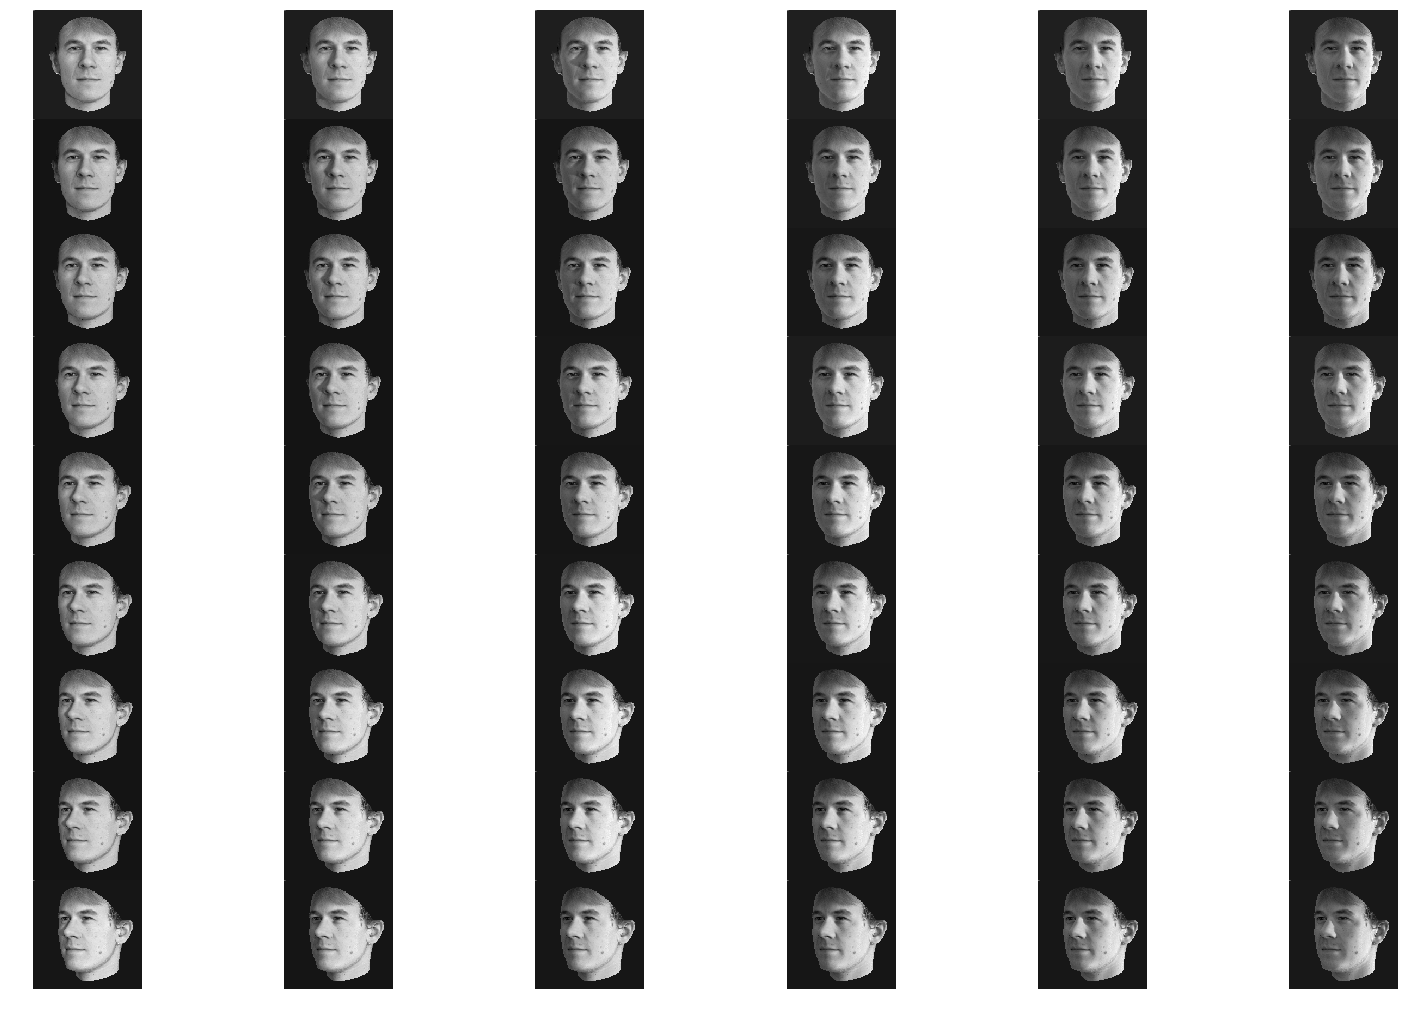

In [17]:
def plot_tensor_slice(T, x_size=x_size, y_size=y_size,  n=0):
    fig = plt.figure(figsize=(3*T.shape[1], 3*T.shape[2]))
    fig.subplots_adjust(wspace=0, hspace=0)
    for i in range(T.shape[1]):
        for j in range(T.shape[2]):
            sub = fig.add_subplot(T.shape[1],T.shape[2],T.shape[2]*i + j+1)
            plt.imshow(T[n,i,j].reshape(x_size, y_size), cmap="gray")
            plt.axis("off")
    plt.show()
plot_tensor_slice(images, n=1)

-----------------

In [26]:
def MPCA(T):
    """ Perform MPCA on the tensor T on the first n dimension of the tensor
        Returns (Z, U, U_T, S, V) where :
            Z is the core tensor
            U is the list of U matrices from the SVD
            U is the list of U^T matrices from the SVD
            S is the list of S matrices from the SVD
            V is the list of V matrices from the SVD
    """
    U = []
    U_T = []
    V = []
    S = []
    for i in range(T.ndim - 1):
        u, s, v = np.linalg.svd(tl.base.unfold(T, i), full_matrices=False)
        U.append(u)
        U_T.append(u.T)
        S.append(s)
        V.append(v)
    return (tl.tenalg.multi_mode_dot(T, U_T, np.arange(T.ndim - 1)), U, U_T, S, V)

In [27]:
Z, U, U_T, S, V = MPCA(images)

In [28]:
Z.shape

(10, 9, 6, 40000)

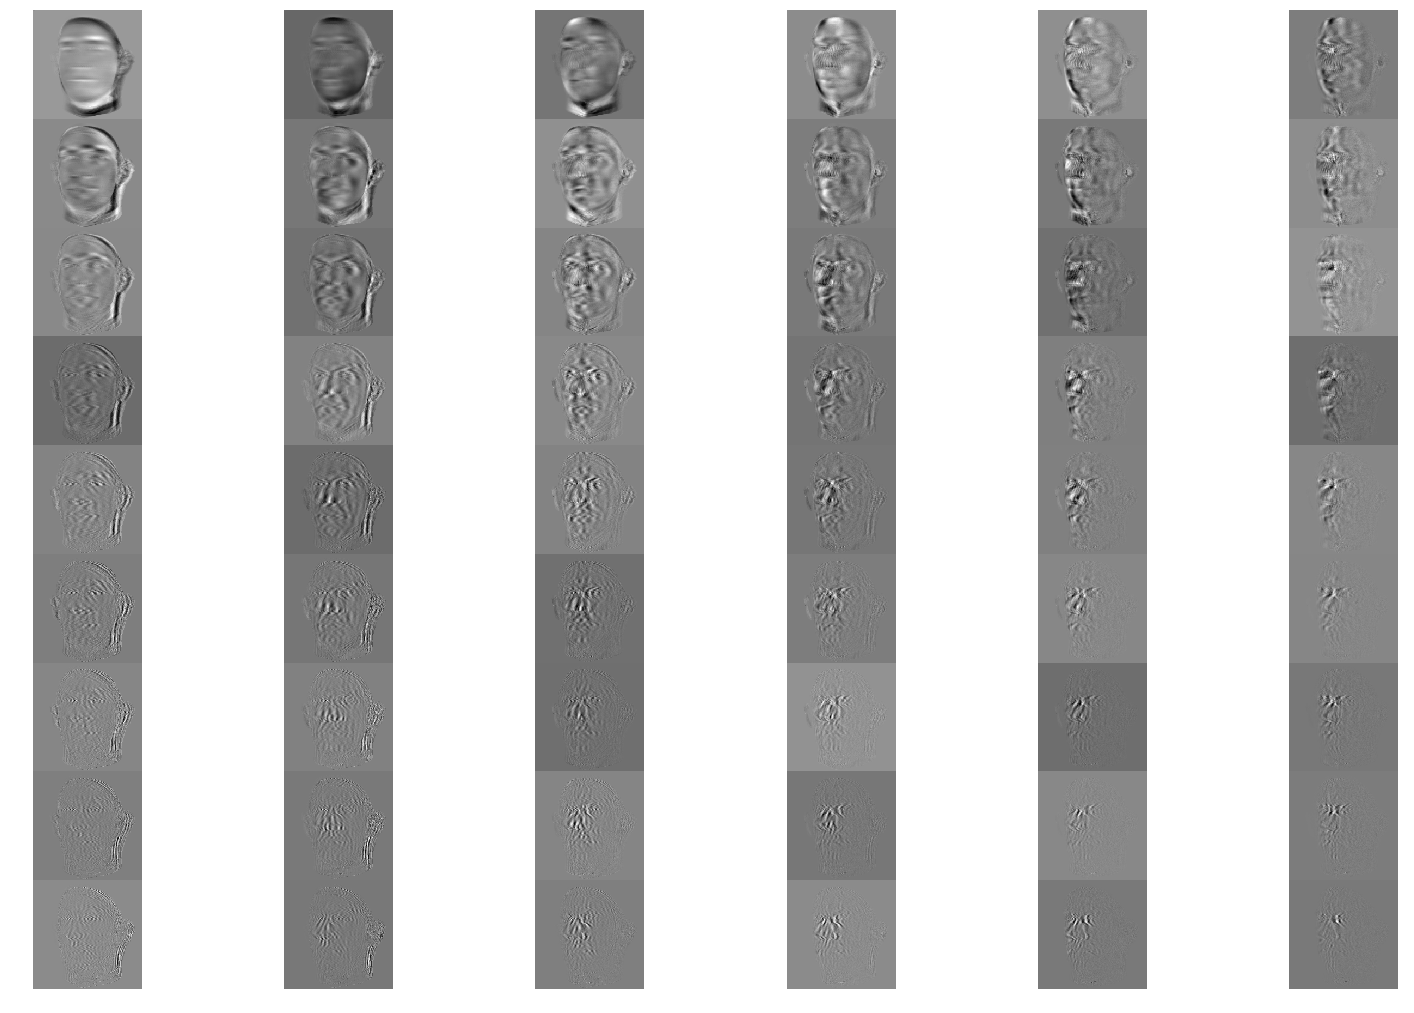

In [30]:
# plt.imshow(Z[0,1,0].reshape(x_size, y_size), cmap="gray")
plot_tensor_slice(Z, n=1)

---------------

In [310]:
def MICA(T, fun="exp"):
    """ Perform MICA on the tensor T on the first n dimension of the tensor
    """
    Z, U, U_T, S, V = MPCA(T)
    W = []
    C = []
    C_1 = []
    for i in range(T.ndim - 1 ):
        w = sklearn.decomposition.fastica_.fastica(tl.base.unfold(T, i), fun=fun)[1]
        W.append(w)
        c = np.dot(U[i], np.linalg.inv(w))
        C.append(c)
        C_1.append(np.linalg.inv(c))
    return tl.tenalg.multi_mode_dot(Z, W, np.arange(T.ndim - 1))

In [322]:
S1 = MICA(images, fun="exp")

/home/adrien/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/home/adrien/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/home/adrien/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


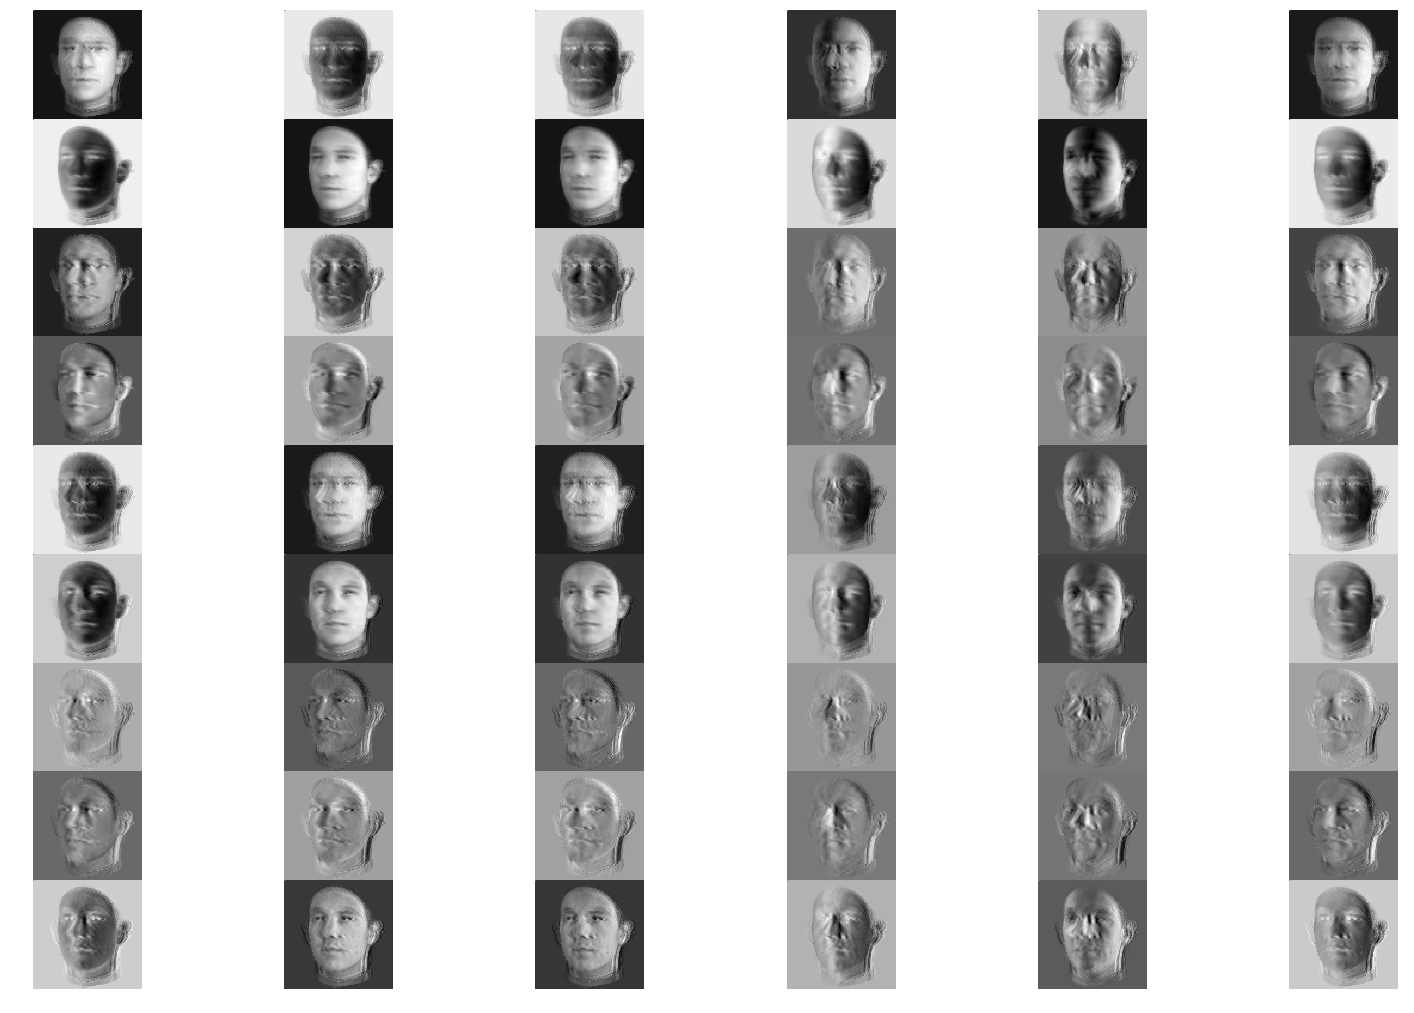

In [323]:
# plt.imshow(S1[1,0,0], cmap="gray")
plot_tensor_slice(S1, n=0)

-----------------
#### Mode-m covarianc matrix

In [88]:
def mode_covariance_matrices(T):
    """ For a tensor T of order 4
        With T.shape = [n_person, n_view, n_illumination, n_pixel]
        Compute the 3 mode covariance matrices.
        Assuming that the mode 4 of T is the measurement mode. Pixel mode in our case
    """
    M = T.ndim
    RBF = sklearn.gaussian_process.kernels.RBF()
    Cov1 = np.zeros((T.shape[0], T.shape[0]))
    for j in range(T.shape[0]):
        for k in range(T.shape[0]):
            for i2 in range(T.shape[1]):
                for i3 in range(T.shape[2]):
#                     Cov1[j,k] += np.exp(-np.linalg.norm((T[j, i2, i3] - T[k, i2, i3]))**2 )
                    Cov1[j,k] += T[j, i2, i3].reshape(1,-1).dot(T[k, i2, i3].reshape(-1,1))**2
                    
    
    Cov2 = np.zeros((T.shape[1], T.shape[1]))
    for j in range(T.shape[1]):
        for k in range(T.shape[1]):
            for i1 in range(T.shape[0]):
                for i3 in range(T.shape[2]):
#                     Cov2[j,k] += np.exp(-np.linalg.norm(T[i1, j, i3]- T[i1, k, i3])**2)
                    Cov2[j,k] += T[i1, j, i3].reshape(1,-1).dot(T[i1, k, i3].reshape(-1,1))**2
    
    Cov3 = np.zeros((T.shape[2], T.shape[2]))
    for j in range(T.shape[2]):
        for k in range(T.shape[2]):
            for i1 in range(T.shape[0]):
                for i2 in range(T.shape[1]):
#                     Cov2[j,k] += np.exp(-np.linalg.norm(T[i1, i2, j]- T[i1, i2, k])**2)
                    Cov2[j,k] += T[i1, i2, j].reshape(1,-1).dot(T[i1, i2, k].reshape(-1,1))**2
    return [Cov1, Cov2, Cov3]

----------------
#### MPCA 2

In [91]:
def HOSVD(T, N=None, ranks=None, iter_max=10, e=1e-3):
    """ Perform HOSVD on the tensor T on the first n modes of the tensor
        and performs the truncated HOSVD, if ranks is given.
        
        Parameters :
            T :
                    the tensor
            n :
                    set to None by default which perform the HOSVD and all the modes
                    if given must be an int >0, the HOSVD is then performed on the n first modes of T
            ranks : 
                    None by default, if given, must be an array of int of size n, and all of its values must be >0
        Returns (Z, U, U_T, S, V) where :
            Z is the core tensor
            U is the list of U matrices from the SVD
            U is the list of U^T matrices from the SVD
            S is the list of S matrices from the SVD
            V is the list of V matrices from the SVD
    """
    assert isinstance(T, np.ndarray)
    if N is None:
        N = T.ndim
    trunc = True #tells if we perform HOSVD with truncation 
    if ranks is None:
        ranks = np.array(T.shape)[:N]
        trunc = False
    assert N == len(ranks)
    
    U = list(np.empty(N))
    U_T = list(np.empty(N))
    V = list(np.empty(N))
    S = list(np.empty(N))
    for i in range(N):
        u, s, v = np.linalg.svd(tl.base.unfold(T, i), full_matrices=False)
        U[i] = u[:, :ranks[i]]
        U_T[i] = u[:, :ranks[i]].T
        S[i] = s[:ranks[i]]
        V[i] = v[:ranks[i]]
    
    if not trunc:
        #if no truncation, then returns the values
        return tl.tenalg.multi_mode_dot(T, U_T, np.arange(N)), U, U_T, S, V
    
    prev = float("inf")
    #otherwise, local optimization using altenating least squares
    for j in range(iter_max):
        for n in range(N):
            # compute X = T x_1 U_1^T ... x_{n-1} U_{n-1}^T x_{n+1} U_{n+1}^T ... x_N U_N^T
            first = True # a flag that tell if we have already computed T x_1 U_1^T
            for i in range(N):
                if i == n: continue
                if first:
                    first = False
                    X = tl.tenalg.mode_dot(T, U_T[i], i)
                else:
                    X = tl.tenalg.mode_dot(X, U_T[i], i)
            U_n, _, _ = np.linalg.svd(tl.base.unfold(X,n), full_matrices=False)
            U_n = U_n[:,:ranks[n]]
            U[n] = U_n
            U_T[n] = U_n.T
        Z = tl.tenalg.mode_dot(X, U_T[N-1], N-1)
        T_2 = tl.tenalg.multi_mode_dot(Z, U, np.arange(N))
        current = np.linalg.norm(T - T_2)**2
        if abs( current - prev) <= e :
            break
        prev = current
    return  Z, U, U_T, S, V

In [89]:
def MPCA2(T, ranks=None ):
    """ Compute MPCA as defined in 4.2.1 of : 
            http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.442.5742&rep=rep1&type=pdf
        T is an order 4 tensor, where the 4th mode is the mesurement mode.
    """
#     assert(T.ndim == 4)
    
    if ranks is None:
        ranks = list(T.shape[:3])
#     assert(len(ranks) == T.ndim -1)
    U = []
    U_T = []
    V = []
    S = []
    Covs = mode_covariance_matrices(T)
    #U, U_T, S, V = HOSVD(T, 3, ranks)
    for i in range(3):
        u, s, v = np.linalg.svd(Covs[i])
        U.append(u[:, :ranks[i]])
        U_T.append(u[:, :ranks[i]].T)
        S.append(s[:ranks[i]])
        V.append(v[:ranks[i]])
    return tl.tenalg.multi_mode_dot(T, U_T, np.arange(3)), U #core tensor
    
    

In [92]:
Z, U, U_T, S, V = HOSVD(images, N=3, ranks=[4,4,4], iter_max=10, e=0.000001 )

In [93]:
Z_2, U_2 = MPCA2(images, ranks=[4,4,4])

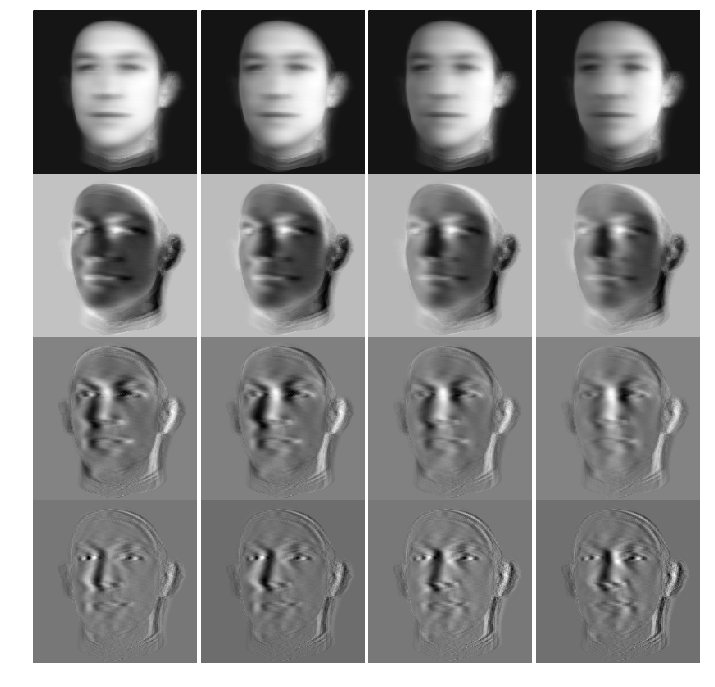

In [95]:
plot_tensor_slice(Z_2, n=0)